# Explore capacity for mapping song patterns to behavioral trajectory via MA code

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

In [5]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integrated response
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [6]:
# get snippets
NTR = 30
T_SNPS = range(180, 320, 16)  # snippet lengths to fetch

ds = np.nan*np.zeros((len(T_SNPS), NTR))  # pairwise distances between neural song snippet representations

durs = []
masses = []

rs_final = []
rs_final_scrambled = []

# save some example snippets and responses
snp_xpls = []
snp_xpl_scrambleds = []

rs_full_xpl = []
rs_full_xpl_scrambled = []


for cT_SNP, T_SNP in enumerate(T_SNPS):
    sys.stdout.write(f'T_SNP {T_SNP}: ')
    
    NT_SNP = int(round(T_SNP*FPS))
    t_snp = np.arange(NT_SNP)*DT

    snps = []

    for csng, sng_full in enumerate(sngs_full):
        
        segs, bds = get_seg(sng_full > 0, min_gap=NT_SNP)
        segs = [sng_full[lb:ub] for lb, ub in bds]
        
        # keep fixed-length portions only of sufficiently long segments
        segs = [seg[:NT_SNP] for seg in segs if (len(seg) >= NT_SNP)]
        
        snps.extend(segs)

    snps_scrambled = [snp[np.random.permutation(len(snp))] for snp in snps]
    
    snps = np.array(snps)
    nsnp = len(snps)
    
    snps_scrambled = np.array(snps_scrambled)

    sys.stdout.write(f'{nsnp} snippets')

    for ctr in range(NTR):
        sys.stdout.write('.')
        isnps = np.random.choice(range(len(snps)), 2, replace=False)
        r_pair = []

        for isnp in isnps:
            # get neural response
            snp = snps[isnp]
            i_s = (snp == 1).astype(float)
            i_p = (snp == 2).astype(float)

            t_snp = np.arange(len(snp))*DT

            rs = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)[0]

            r_pair.append(rs[-1, :])
            
            rs_final.append(rs[-1, :])
            
            durs.append(T_SNP)
            masses.append(np.sum(snp > 0)*DT)
            
            # get neural response to scrambled snippet
            snp_scrambled = snps_scrambled[isnp]
            
            i_s_scrambled = (snp_scrambled == 1).astype(float)
            i_p_scrambled = (snp_scrambled == 2).astype(float)
            
            rs_scrambled = smlt(i_s_scrambled, i_p_scrambled, tau_r, tau_a, x_s, x_p)[0]
            
            rs_final_scrambled.append(rs_scrambled[-1, :])
            
            if np.random.rand() < .1:  # randomly save some examples
                snp_xpls.append(snp.copy())
                rs_full_xpl.append(rs.copy())
                
                snp_xpl_scrambleds.append(snp_scrambled.copy())
                rs_full_xpl_scrambled.append(rs_scrambled.copy())
                

        d = np.linalg.norm(r_pair[0] - r_pair[1])
        
        ds[cT_SNP, ctr] = d
    print('')
    
durs = np.array(durs)
masses = np.array(masses)

T_SNP 180: 69 snippets..............................
T_SNP 196: 66 snippets..............................
T_SNP 212: 65 snippets..............................
T_SNP 228: 62 snippets..............................
T_SNP 244: 61 snippets..............................
T_SNP 260: 59 snippets..............................
T_SNP 276: 58 snippets..............................
T_SNP 292: 57 snippets..............................
T_SNP 308: 55 snippets..............................


In [8]:
snps_long = [snp_xpl_ for snp_xpl_ in snp_xpls if len(snp_xpl_) >= 180*FPS]
rs_full_long = [rs_full_xpl_ for rs_full_xpl_ in rs_full_xpl if len(rs_full_xpl_) >= 180*FPS]

## Trained readouts

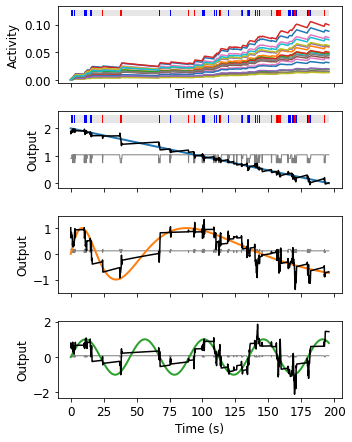

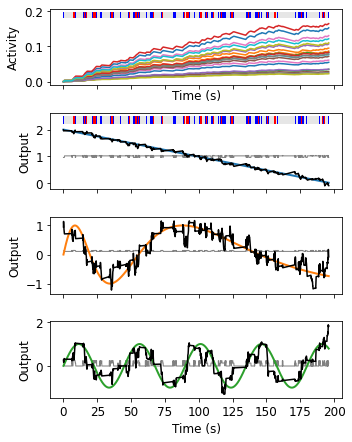

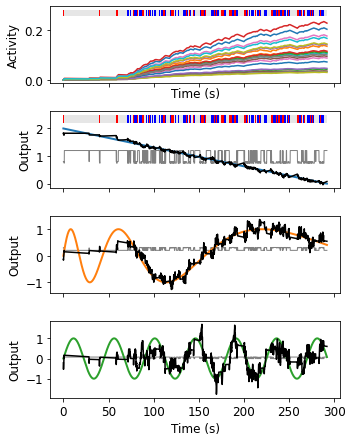

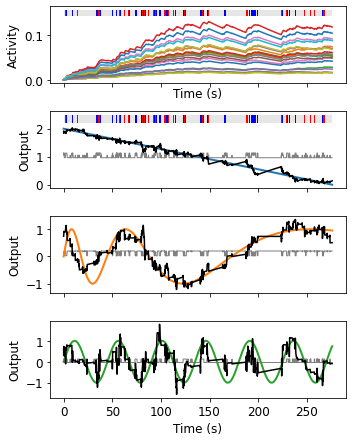

In [34]:
ITR_XPLS = [0, 1, 30, 25]
ALPHA = 1e-15

for itr_xpl in ITR_XPLS:

    snp_xpl = snps_long[itr_xpl]
    rs_xpl = rs_full_long[itr_xpl]
    t = np.arange(len(rs_xpl))*DT

    ys = [
        2*(t.max() - t.copy())/t.max(),
        np.sin(2*np.pi*t/np.linspace(30, 120, len(t))),
        np.sin(2*np.pi*t/45),
    ]

    fig, axs = plt.subplots(len(ys)+1, 1, figsize=(5, 6.25), tight_layout=True, sharex=True)
    axs[0].plot(t, rs_xpl)
    plot_b(axs[0], t, snp_xpl, [0, t.max(), 1.1*rs_xpl.max(), 1.2*rs_xpl.max()], [(.9, .9, .9), 'b', 'r'])
    set_plot(axs[0], x_label='Time (s)', y_label='Activity')
    
    i_s = (snp_xpl == 1)
    i_p = (snp_xpl == 2)
    
    x_snp = np.array([i_s, i_p]).T

    for cy, (ax, y) in enumerate(zip(axs[1:], ys)):
        rgr = linear_model.Ridge(alpha=ALPHA)
        rgr.fit(rs_xpl, y)
        y_hat = rgr.predict(rs_xpl)

        ax.plot(t, y, c=colors[cy], lw=2)
        ax.plot(t, y_hat, c='k')
        
        rgr_snp = linear_model.Ridge(alpha=ALPHA)
        rgr_snp.fit(x_snp, y)
        y_hat_snp = rgr_snp.predict(x_snp)
        
        ax.plot(t, y_hat_snp, c='gray', lw=1, zorder=-1)

        if ax is axs[1]:
            plot_b(ax, t, snp_xpl, [0, t.max(), 1.1*y.max(), 1.25*y.max()], [(.9, .9, .9), 'b', 'r'])

        set_plot(ax, y_label='Output', font_size=12)
        if ax is axs[-1]:
            set_plot(ax, x_label='Time (s)', font_size=12)
            
    fig.savefig(f'supp/4_lin_readout_examples_{itr_xpl}.svg')